# Методы машинного обучения – Контрольная работа №5

# Нейронные сети CNN

Импортируем необходимые библиотеки:

In [1]:
# !pip install -q tfds-nightly
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds

## Загрузка набора "лошади или люди" (horses_or_humans)

Загрузим из __Tensorflow datasets__ набор данных `horses_or_humans`:

In [2]:
ds_train = tfds.load("horses_or_humans", split='train')
df_train = tfds.as_dataframe(ds_train)
df_train.head(3)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\Mo\tensorflow_datasets\horses_or_humans\incomplete.LBMPYZ_3.0.0\horses_or_humans-train.tfre…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\Mo\tensorflow_datasets\horses_or_humans\incomplete.LBMPYZ_3.0.0\horses_or_humans-test.tfrec…

Dataset horses_or_humans downloaded and prepared to C:\Users\Mo\tensorflow_datasets\horses_or_humans\3.0.0. Subsequent calls will reuse this data.


image  label
0  [[[53, 55, 45], [46, 47, 40], [39, 40, 36], [3...      0
1  [[[255, 227, 204], [253, 226, 203], [251, 223,...      0
2  [[[157, 180, 202], [157, 180, 202], [157, 180,...      0

Загрузим из обучающей выборки первое изображение:

In [3]:
from PIL import Image, ImageOps

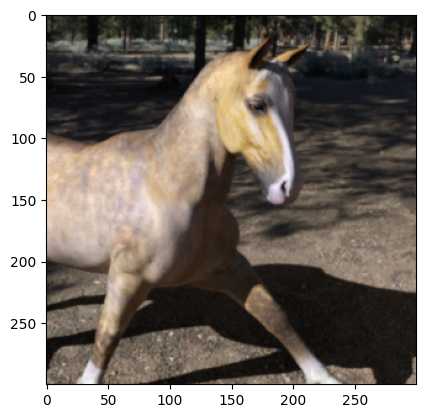

In [4]:
img = Image.fromarray(df_train.iloc[0]['image'])
plt.imshow(img);

Изображение является цветным и использует три канала:

In [5]:
np.array(img).shape

(300, 300, 3)

Чтобы упростить работу с изображением, перейдем к изображению с оттенками серого:

In [6]:
img = ImageOps.grayscale(img)
np.array(img).shape

(300, 300)

Для визуализации будем использовать следующие функции:

In [7]:
def plot_image(img: np.array):
    plt.figure(figsize=(6, 6))
    plt.imshow(img, cmap='gray');

def plot_two_images(img1: np.array, img2: np.array):
    _, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(img1, cmap='gray')
    ax[1].imshow(img2, cmap='gray');

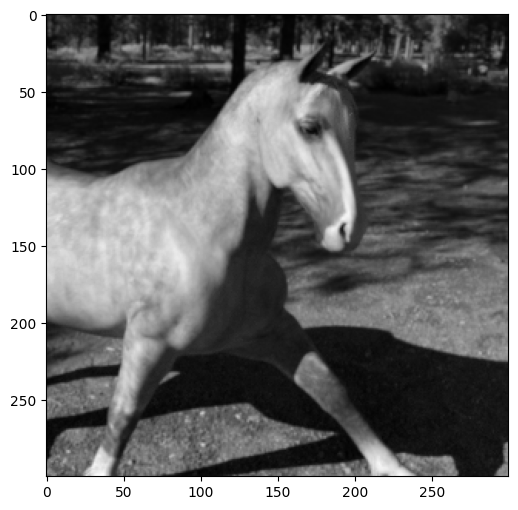

In [8]:
plot_image(img=img)

## Свертка изображения

Свертка сводится к повторяющемуся матричному поэлементному умножению и суммированию, которое может быть легко реализовано.

### Фильтры для свертки

Задача сверточного слоя — найти фильтры (ядра), которые лучше всего извлекают признаки из набора данных с изображениями.

Рассмотрим следующие матрицы размерами 3x3:

In [9]:
sharpen = np.array([
    [0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]
])

blur = np.array([
    [0.0625, 0.125, 0.0625],
    [0.125,  0.25,  0.125],
    [0.0625, 0.125, 0.0625]
])

outline = np.array([
    [-1, -1, -1],
    [-1,  8, -1],
    [-1, -1, -1]
])

## Реализация свертки

Объявим вспомогательную функцию, которая будет вычислять размеры изображения.

Например, при использовании фильтра 3x3 будем терять по одному пикселю с каждого края.

In [10]:
def calculate_target_size(img_size: int, kernel_size: int) -> int:
    num_pixels = 0

    for i in range(img_size):
        added = i + kernel_size
        if added <= img_size:
            num_pixels += 1

    return num_pixels

In [11]:
calculate_target_size(img_size=300, kernel_size=3)

298

In [12]:
calculate_target_size(img_size=300, kernel_size=5)

296

Свертка работает так:
1. Извлекаем первую матрицу 3x3 из изображения:

In [13]:
subset = np.array(img)[0:0+3, 0:0+3]
subset

array([[53, 46, 39],
       [40, 48, 53],
       [30, 47, 59]], dtype=uint8)

2. Производим поэлементное умножение изображения на фильтр:

In [14]:
np.multiply(subset, sharpen)

array([[  0, -46,   0],
       [-40, 240, -53],
       [  0, -47,   0]])

3. Суммируем элементы матрицы:

In [15]:
np.sum(np.multiply(subset, sharpen))

54

Применим эту логику ко всей матрице. Нужно перебрать все допустимые строки и столбцы в изображении, а затем умножить на фильтр и просуммировать.

In [16]:
def convolve(img: np.array, kernel: np.array) -> np.array:
    # Assuming a rectangular image
    tgt_size = calculate_target_size(
        img_size=img.shape[0],
        kernel_size=kernel.shape[0]
    )
    # To simplify things
    k = kernel.shape[0]

    # 2D array of zeros
    convolved_img = np.zeros(shape=(tgt_size, tgt_size))

    # Iterate over the rows
    for i in range(tgt_size):
        # Iterate over the columns
        for j in range(tgt_size):
            # img[i, j] = individual pixel value
            # Get the current matrix
            mat = img[i:i+k, j:j+k]

            # Apply the convolution - element-wise multiplication and summation of the result
            # Store the result to i-th row and j-th column of our convolved_img array
            convolved_img[i, j] = np.sum(np.multiply(mat, kernel))

    return convolved_img

Применим фильтр повышения резкости в первую очередь:

In [17]:
img_sharpened = convolve(img=np.array(img), kernel=sharpen)
img_sharpened

array([[ 54.,  79.,  40., ...,  19.,  14.,  12.],
       [ 55., 104.,  56., ...,  16.,  20.,  11.],
       [ 39.,  51.,  18., ...,  23.,  17.,  15.],
       ...,
       [184., 157., 144., ..., 144., 144.,  96.],
       [185., 100., 112., ..., 145., 107.,  87.],
       [170., 167., 181., ..., 138., 120., 142.]])

Визуализируем исходное и полученное изображения:

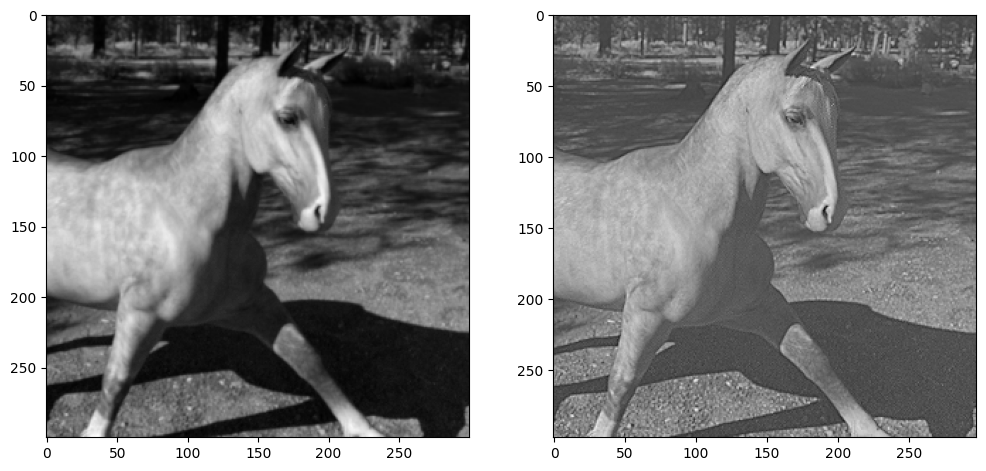

In [18]:
plot_two_images(
    img1=img,
    img2=img_sharpened
)

Оттенки немного отличаются, так как значения в матрице `img_sharpened` не находятся в диапазоне от 0 до 255. Можно исправить это, заменив все отрицательные значения нулями:

In [19]:
def negative_to_zero(img: np.array) -> np.array:
    img = img.copy()
    img[img < 0] = 0
    return img

Снова выполним визуализацию:

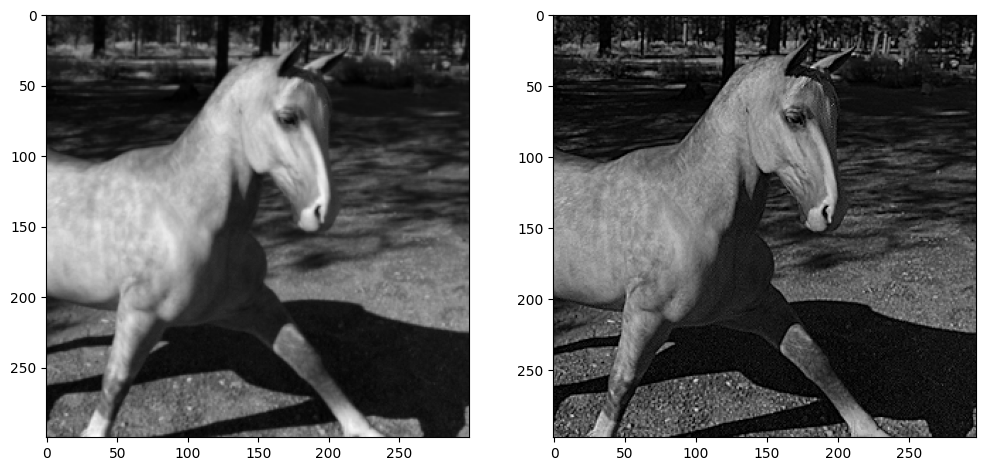

In [20]:
plot_two_images(
    img1=img,
    img2=negative_to_zero(img=img_sharpened)
)

Изображение определенно выглядит более четким.

Теперь сделаем изображение более размытым:

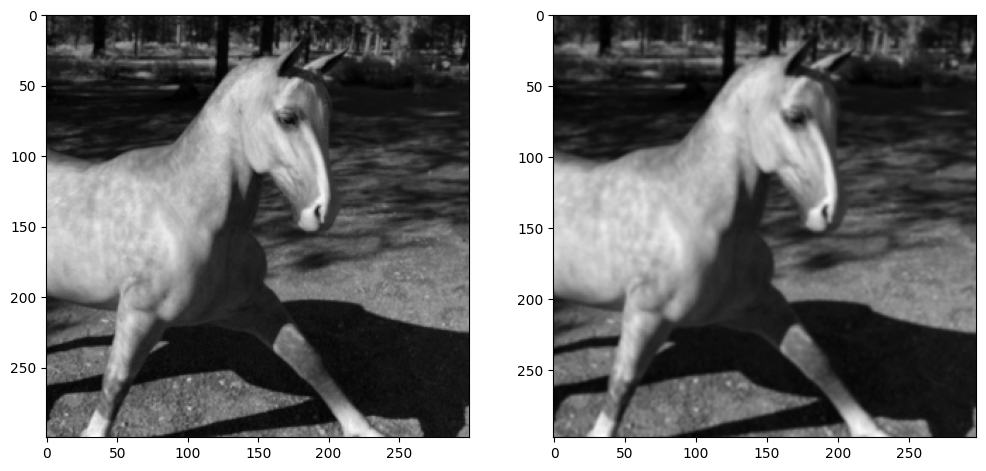

In [21]:
img_blurred = convolve(img=np.array(img), kernel=blur)
plot_two_images(
    img1=img,
    img2=img_blurred
)

Матрица фильтра размытия не имеет отрицательных значений, поэтому оттенки идентичны.

Наконец, давайте применим фильтр контура:

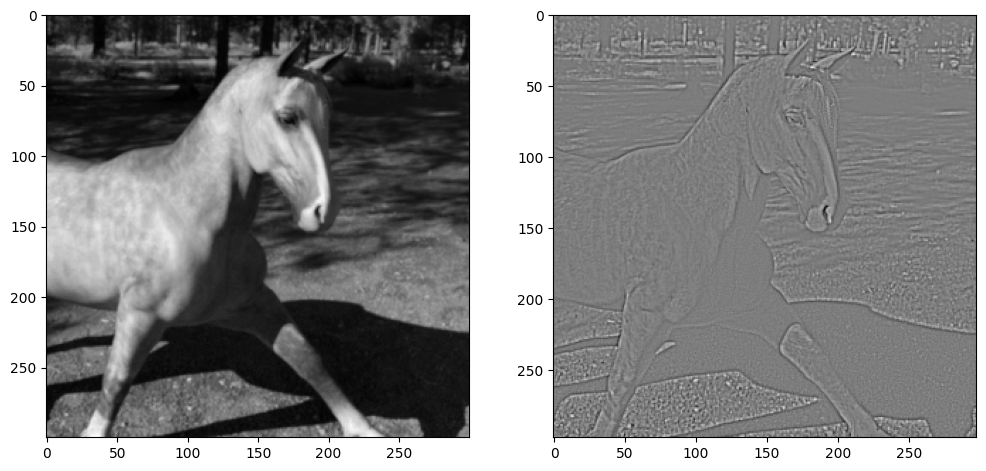

In [22]:
img_outlined = convolve(img=np.array(img), kernel=outline)
plot_two_images(
    img1=img,
    img2=img_outlined
)

Этот фильтр также требует корректировки оттенков:

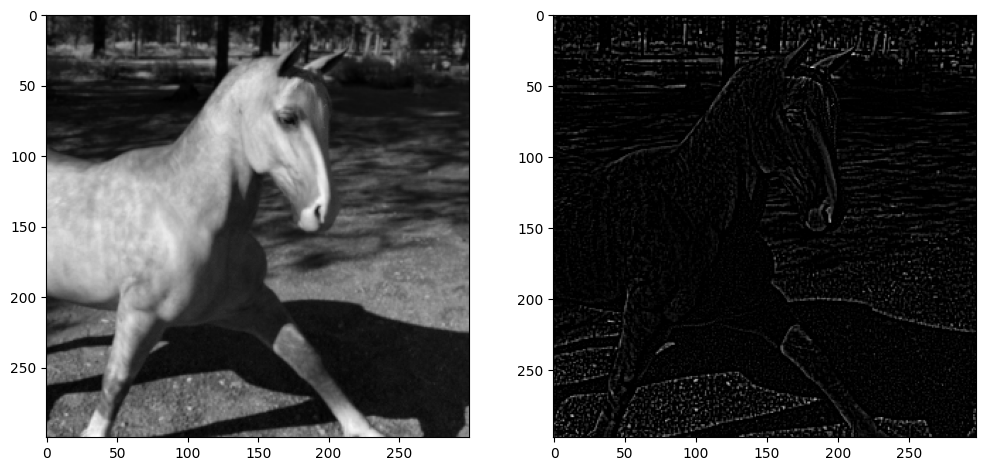

In [23]:
plot_two_images(
    img1=img,
    img2=negative_to_zero(img=img_outlined)
)

Все изображения после свертки имеют размеры 298x298.

In [24]:
np.array(img_sharpened).shape, np.array(img_blurred).shape, np.array(img_outlined).shape

((298, 298), (298, 298), (298, 298))

### Реализация свертки с заполнением отступа (padding)

Слой TensorFlow `Conv2D` позволяет указывать для параметра `padding` значения `valid` или `same`.

Первый вариант (по умолчанию) означает, что к изображениям не добавляется отступ.
Второй вариант добавляет отступы в зависимости от размера фильтра (ядра), поэтому исходное и свернутое изображения имеют одинаковую форму. Отступы - это, по сути, просто черная рамка вокруг изображения с добавленными нулями. Нули не влияют на вычисления, так как операция свертки умножает элементы изображения на элементы фильтра. Любой множитель, умноженный на ноль, дает в результате ноль.

Объявим вспомогательную функцию, которая вычисляет, насколько «толстую» границу нам нужно добавить к изображению.

In [25]:
def get_padding_width_per_side(kernel_size: int) -> int:
    return kernel_size // 2 # целочисленное деление

In [26]:
pad_3x3 = get_padding_width_per_side(kernel_size=3)
pad_3x3

1

In [27]:
pad_5x5 = get_padding_width_per_side(kernel_size=5)
pad_5x5

2

Объявим еще одну вспомогательную функцию, задача которой добавить отступ к изображению. Функция объявляет матрицу нулей формы `(image.shape + padding * 2)`. Отступы умножаются на 2, потому что они нужны со всех сторон. Затем мы индексируем матрицу, чтобы проигнорировать заполнение, и заменяем нули фактическими значениями изображения:

In [28]:
def add_padding_to_image(img: np.array, padding_width: int) -> np.array:
    # Array of zeros of shape (img + padding_width)
    img_with_padding = np.zeros(shape=(
        img.shape[0] + padding_width * 2,  # Multiply with two because we need padding on all sides
        img.shape[1] + padding_width * 2
    ))

    # Change the inner elements
    # For example, if img.shape = (224, 224), and img_with_padding.shape = (226, 226)
    # keep the pixel wide padding on all sides, but change the other values to be the same as img
    img_with_padding[padding_width:-padding_width, padding_width:-padding_width] = img

    return img_with_padding

(302, 302)


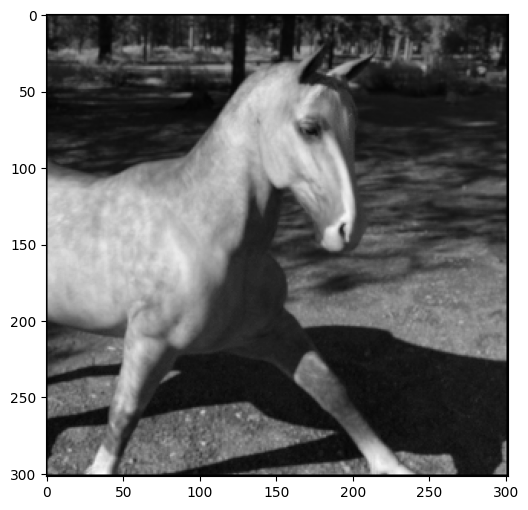

In [29]:
img_with_padding_3x3 = add_padding_to_image(
    img=np.array(img),
    padding_width=pad_3x3
)

print(img_with_padding_3x3.shape)
plot_image(img_with_padding_3x3)

In [30]:
img_with_padding_3x3

array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,  53.,  46., ...,  22.,  20.,   0.],
       [  0.,  40.,  48., ...,  17.,  17.,   0.],
       ...,
       [  0., 128., 138., ..., 138., 146.,   0.],
       [  0., 105., 107., ..., 144., 153.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])

(304, 304)


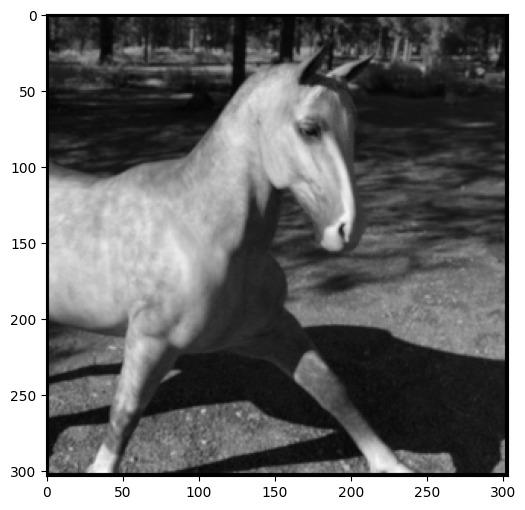

In [31]:
img_with_padding_5x5 = add_padding_to_image(
    img=np.array(img),
    padding_width=pad_5x5
)

print(img_with_padding_5x5.shape)
plot_image(img_with_padding_5x5)

In [32]:
img_with_padding_5x5

array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,  53., ...,  20.,   0.,   0.],
       ...,
       [  0.,   0., 105., ..., 153.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])

Применим операцию свертки к нашему изображению 302x302 (граница шириной 1 пиксель):

In [33]:
img_padded_3x3_sharpened = convolve(img=img_with_padding_3x3,
                                    kernel=sharpen)
img_padded_3x3_sharpened.shape

(300, 300)

В результате получается изображение размером 300x300, такое же, как и исходное.
Построим оба изображения рядом, чтобы проверить:

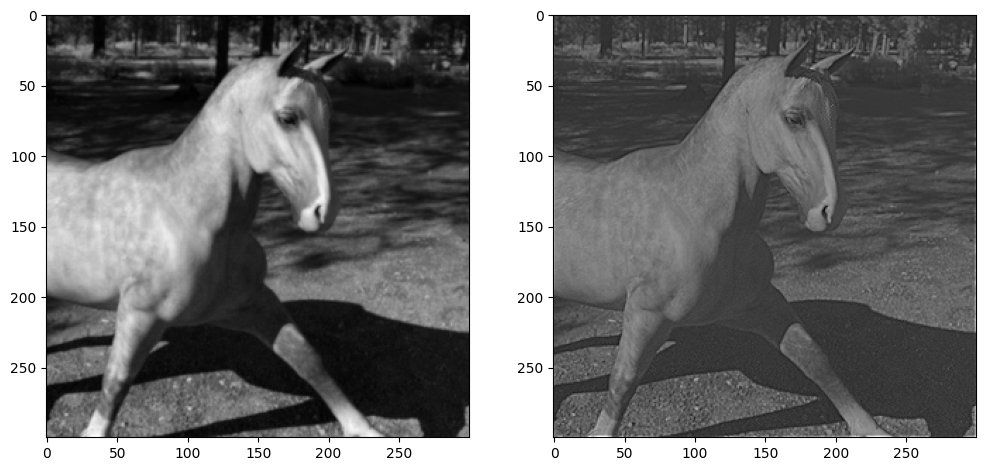

In [34]:
plot_two_images(
    img1=img,
    img2=img_padded_3x3_sharpened
)

## Пулинг (pooling)

Пулинг сводится к разделению 2D-массива на более мелкие фрагменты, что может быть легко реализовано.

Объявим небольшой 2D-массив, который будет представлять выходные данные сверточного слоя:

In [35]:
conv_output = np.array([
    [10, 12,  8,  7],
    [ 4, 11,  5,  9],
    [18, 13,  7,  7],
    [ 3, 15,  2,  2]
])
conv_output

array([[10, 12,  8,  7],
       [ 4, 11,  5,  9],
       [18, 13,  7,  7],
       [ 3, 15,  2,  2]])

Для пулинга нужно выбрать значения для двух гиперпараметров:
* `pool_size` — размер области, скользящей по изображению
* `stride` - количество пикселей, на которое область перемещается по изображению

Общепринятые размеры: 2 x 2 для размера пула (`pool_size`) и 2 для шага (`stride`).
Выбор этих значений уменьшит размер результата свертки вдвое.
Размер пула 2 x 2 и шаг 1 уменьшат размер изображения на один пиксель, что не имеет особого смысла.

In [36]:
# Define paramters
pool_size = 2
stride = 2

# For all rows with the step size of 2 (row 0 and row 2)
for i in np.arange(conv_output.shape[0], step=stride):
    # For all columns with the step size of 2 (column 0 and column 2)
    for j in np.arange(conv_output.shape[0], step=stride):
        # Get a single pool
        mat = conv_output[i:i+pool_size, j:j+pool_size]

        # Ensure that the shape of the matrix is 2x2 (pool size)
        if mat.shape == (pool_size, pool_size):
            # Print it
            print(mat)
    # Print a new line when the code reaches the end of a single row block
    print()

[[10 12]
 [ 4 11]]
[[8 7]
 [5 9]]

[[18 13]
 [ 3 15]]
[[7 7]
 [2 2]]



Оформим все это в виде функции:

In [37]:
def get_pools(img: np.array, pool_size: int, stride: int) -> np.array:
    # To store individual pools
    pools = []

    # Iterate over all row blocks (single block has `stride` rows)
    for i in np.arange(img.shape[0], step=stride):
        # Iterate over all column blocks (single block has `stride` columns)
        for j in np.arange(img.shape[0], step=stride):

            # Extract the current pool
            mat = img[i:i+pool_size, j:j+pool_size]

            # Make sure it's rectangular - has the shape identical to the pool size
            if mat.shape == (pool_size, pool_size):
                # Append to the list of pools
                pools.append(mat)

    # Return all pools as a Numpy array
    return np.array(pools)

In [38]:
test_pools = get_pools(img=conv_output, pool_size=2, stride=2)
test_pools

array([[[10, 12],
        [ 4, 11]],

       [[ 8,  7],
        [ 5,  9]],

       [[18, 13],
        [ 3, 15]],

       [[ 7,  7],
        [ 2,  2]]])

### Макс-пулинг (MaxPooling)

`MaxPooling` — самый распространенный тип пулинга, сохраняющий только самое большое значение из одного пула.

**Логика макс-пулинга**
1. Получить общее количество пулов - длину матрицы `pools` (или `shape[0]`)
2. Рассчитать целевую форму - размер изображения после выполнения операции объединения.
     - Рассчитывается как: квадратный корень из числа пулов, представленных как целое число.
     - Если `num_pools` равно 16, то нужна матрица 4x4 (sqrt(16) = 4)
3. Перебрать все пулы и вычислить максимальное значение — добавить максимальное значение в список результатов.
4. Вернуть результат в виде массива Numpy, преобразованного в целевую форму.

In [39]:
def max_pooling(pools: np.array) -> np.array:
    # Total number of pools
    num_pools = pools.shape[0]
    # Shape of the matrix after pooling - Square root of the number of pools
    # Cast it to int, as Numpy will return it as float
    # For example -> np.sqrt(16) = 4.0 -> int(4.0) = 4
    tgt_shape = (int(np.sqrt(num_pools)), int(np.sqrt(num_pools)))
    # To store the max values
    pooled = []

    # Iterate over all pools
    for pool in pools:
        # Append the max value only
        pooled.append(np.max(pool))

    # Reshape to target shape
    return np.array(pooled).reshape(tgt_shape)

In [40]:
max_pooling(pools=test_pools)

array([[12,  9],
       [18,  7]])

### Пулинг на реальном изображении

In [41]:
np.array(img).shape

(300, 300)

In [42]:
img_pools = get_pools(img=np.array(img), pool_size=2, stride=2)
img_pools.shape

(22500, 2, 2)

In [43]:
max_pooled = max_pooling(pools=img_pools)
max_pooled.shape

(150, 150)

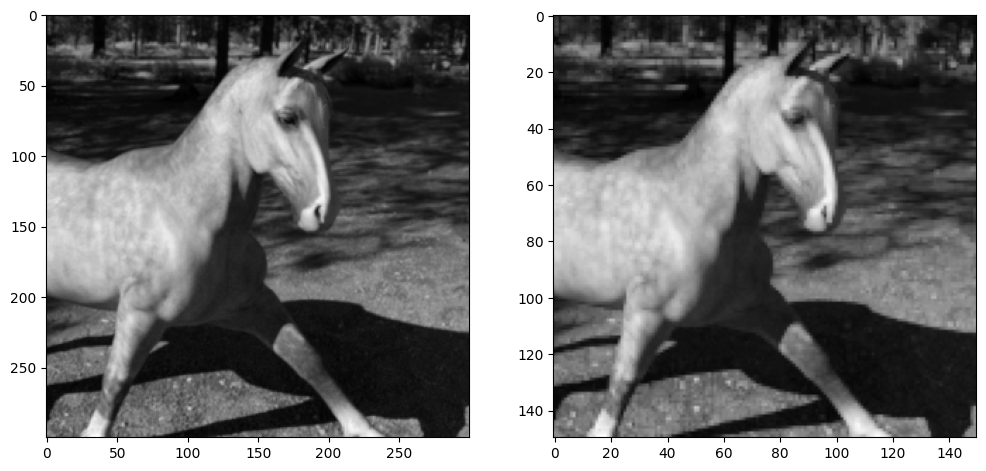

In [44]:
plot_two_images(img1=img, img2=max_pooled)

Изображение справа отображается в том же размере, что и изображение слева, несмотря на то, что оно меньше — проверьте значения по осям X и Y.

### Пулинг при помощи TensorFlow

In [45]:
model = tf.keras.Sequential([
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2)
])

Эту модель не нужно обучать. Но нужно изменить форму изображения, приведя ее к формату:
* (batch size, width, height, number of color channels)

In [46]:
img_arr = np.array(img).reshape(1, 300, 300, 1)
img_arr.shape

(1, 300, 300, 1)

Можно воспользоваться методом `predict()`, чтобы применить пулинг. Будет возвращен тензор размеров 1x150x150x1, поэтому нужно изменить его форму на 150x150:

In [47]:
output = model.predict(img_arr).reshape(150, 150)
output

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


array([[ 53.,  53.,  32., ...,  35.,  25.,  22.],
       [ 47.,  59.,  29., ...,  21.,  19.,  15.],
       [ 60.,  70.,  31., ...,  19.,  16.,  15.],
       ...,
       [129., 130.,  96., ..., 131., 145., 141.],
       [149., 138., 125., ..., 143., 141., 145.],
       [138., 141., 143., ..., 147., 144., 153.]], dtype=float32)

При помощи функции `array_equal()` из Numpy можно проверить, что два массива равны:

In [48]:
np.array_equal(max_pooled, output)

True

## Набор "лошади или люди" (horses_or_humans)

Вернемся к набору данных `horses_or_humans` и создадим обучающие и тестовые наборы данных:

In [49]:
ds = tfds.load("horses_or_humans", split=['train','test'])
df_train = tfds.as_dataframe(ds[0])
df_test  = tfds.as_dataframe(ds[1])
df_train.shape, df_test.shape

((1027, 2), (256, 2))

In [50]:
df_train.iloc[0]['image'].shape

(300, 300, 3)

In [51]:
train_labels = df_train['label'].to_numpy(dtype=np.float32)
test_labels = df_test['label'].to_numpy(dtype=np.float32)
train_labels.shape, test_labels.shape

((1027,), (256,))

In [52]:
train_images = np.zeros(shape=(df_train.shape[0],300,300,3), dtype=np.float32)
test_images  = np.zeros(shape=(df_test.shape[0],300,300,3), dtype=np.float32)
train_images.shape, test_images.shape

((1027, 300, 300, 3), (256, 300, 300, 3))

In [53]:
for idx in range(train_labels.shape[0]):
    train_images[idx,:,:,:] = \
        np.array(Image.fromarray(df_train.iloc[idx]['image']))

for idx in range(test_labels.shape[0]):
    test_images[idx,:,:,:] = \
        np.array(Image.fromarray(df_test.iloc[idx]['image']))

train_images.shape, test_images.shape

((1027, 300, 300, 3), (256, 300, 300, 3))

In [54]:
train_images /= 255
test_images  /= 255

## Визуализация изображений

Всегда рекомендуется визуализировать некоторые изображения при работе с наборами данных изображений.
Функция ниже отображает случайное подмножество из 10 изображений набора данных в сетке из 2 строк и 5 столбцов:

In [55]:
import random

def plot_random_sample(images):
    n = 10
    imgs = random.sample(list(images), n)

    num_row = 2
    num_col = 5

    fig, axes = plt.subplots(num_row, num_col, figsize=(3.5 * num_col, 3 * num_row))
    # For every image
    for i in range(num_row * num_col):
        # Read the image
        img = imgs[i]
        # Display the image
        ax = axes[i // num_col, i % num_col]
        ax.imshow(img)

    plt.tight_layout()
    plt.show()

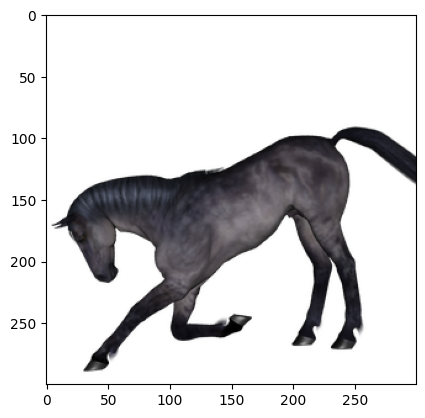

In [56]:
plt.imshow(test_images[1])

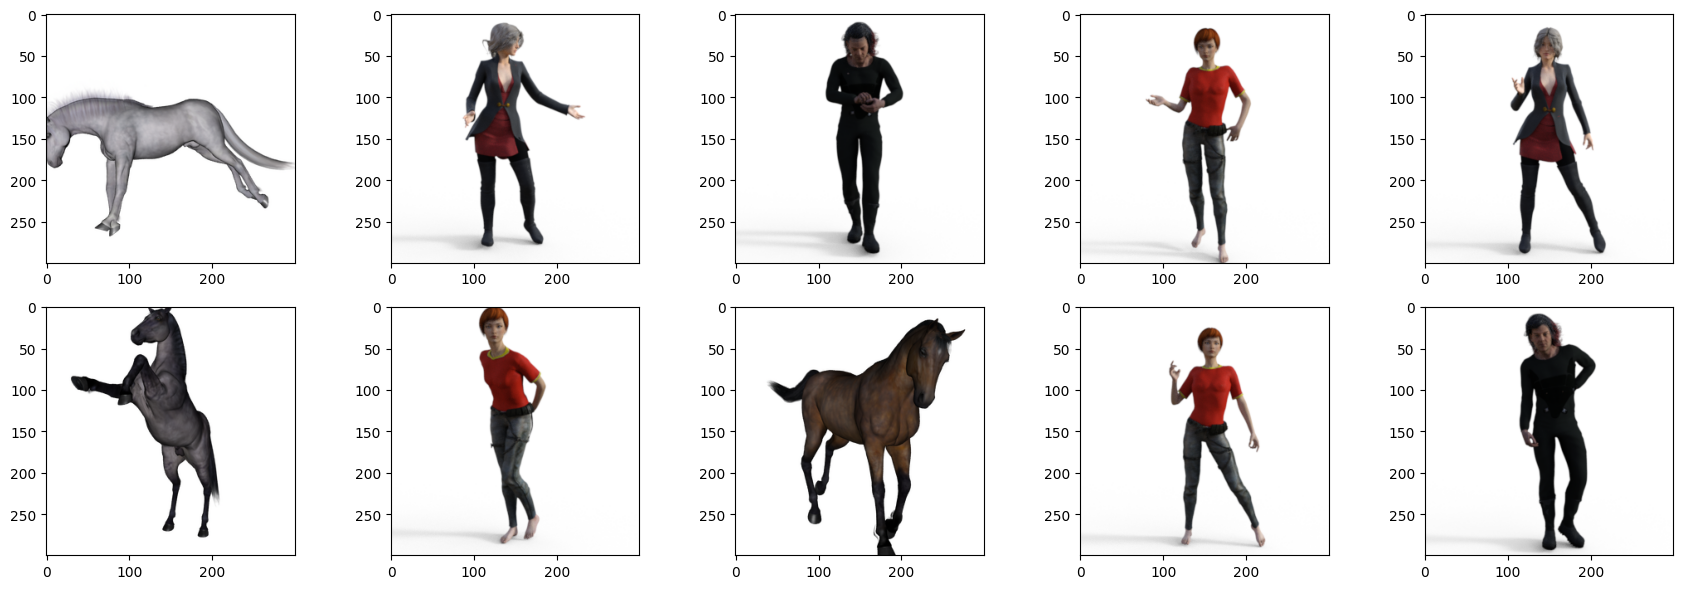

In [57]:
plot_random_sample(test_images)

## Обучение нейронной сети MLP

В качестве функции потерь используется бинарная кросс-энтропия.

In [58]:
tf.random.set_seed(42)

model_1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(300, 300, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_1.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')]
)

history_1 = model_1.fit(
    train_images,
    train_labels,
    epochs=50,
    batch_size=128,
    validation_data=(test_images, test_labels)
)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.4604 - loss: 56.6266 - val_accuracy: 0.6016 - val_loss: 9.1220
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.7099 - loss: 4.0640 - val_accuracy: 0.5703 - val_loss: 10.3669
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.7109 - loss: 4.0297 - val_accuracy: 0.8008 - val_loss: 4.1210
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.8129 - loss: 2.0160 - val_accuracy: 0.5195 - val_loss: 22.3366
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.7295 - loss: 4.7960 - val_accuracy: 0.5000 - val_loss: 46.3962
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.6857 - loss: 8.6716 - val_accuracy: 0.8164 - val_loss: 4.8519
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.8371 - loss: 2.3538 - val_accuracy: 0.8398 - val_loss: 4.0507
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.8905 - loss: 0.9121 - val_accuracy: 0.8477 - val_l

## Показатели качества модели

Визуализируем потери на обучающей и тестовой выборках и долю верных ответов (accuracy) на обучающей и тестовой выборках.

In [59]:
from matplotlib import rcParams

rcParams['figure.figsize'] = (18, 8)
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False

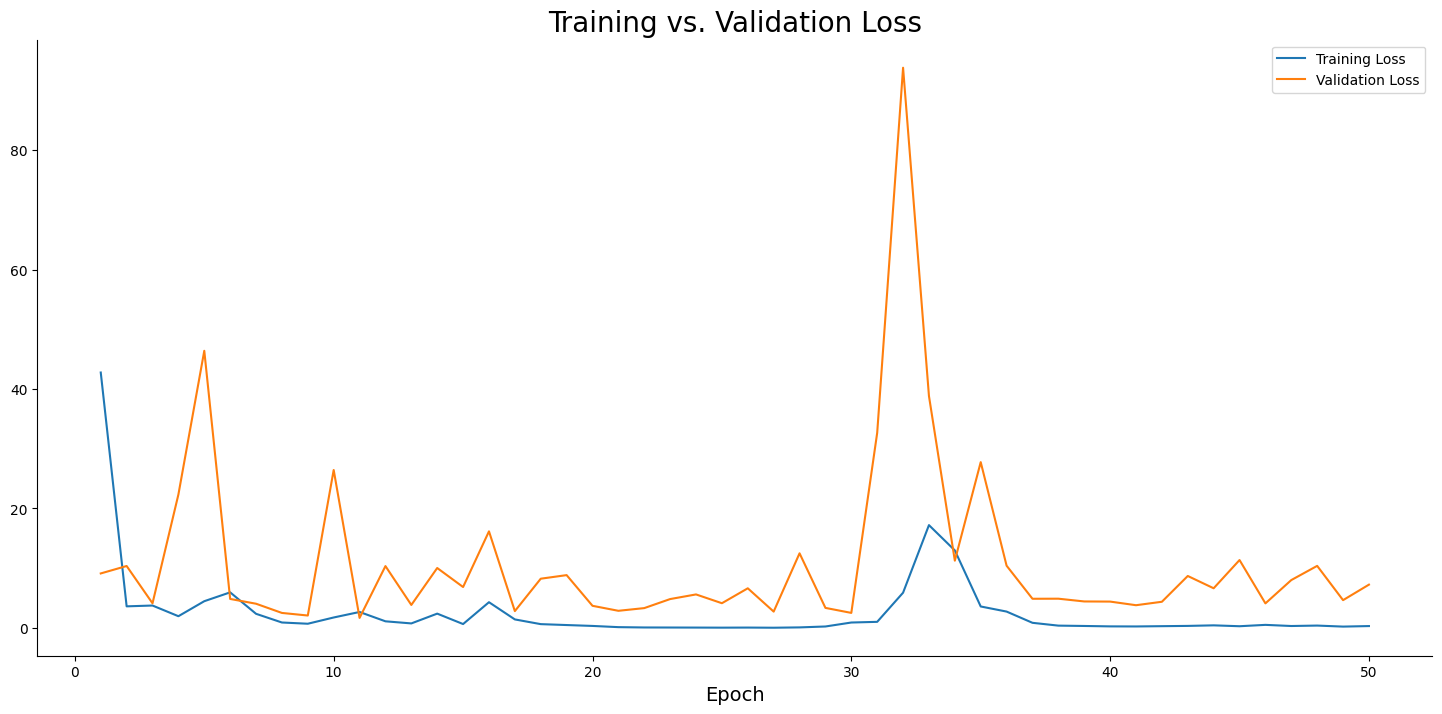

In [60]:
plt.plot(np.arange(1, 51), history_1.history['loss'], label='Training Loss')
plt.plot(np.arange(1, 51), history_1.history['val_loss'], label='Validation Loss')
plt.title('Training vs. Validation Loss', size=20)
plt.xlabel('Epoch', size=14)
plt.legend();

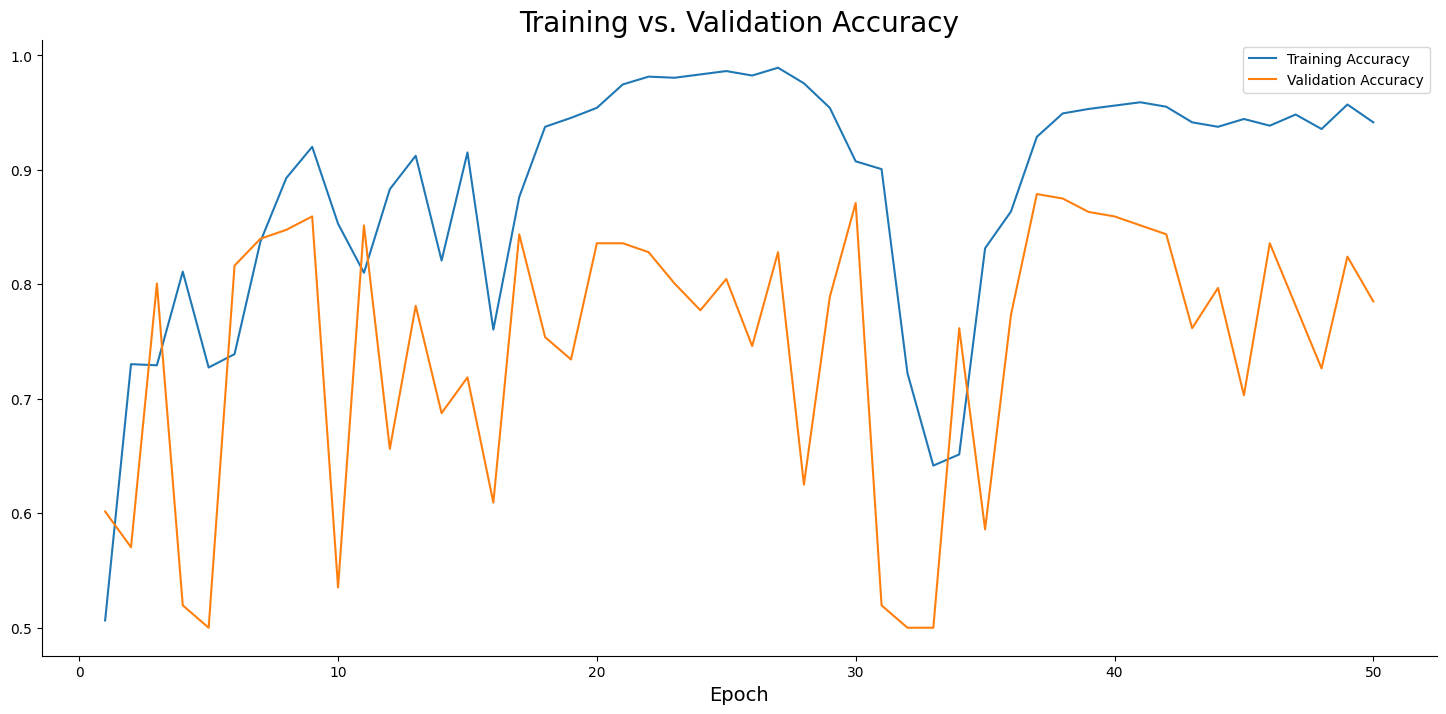

In [61]:
plt.plot(np.arange(1, 51), history_1.history['accuracy'], label='Training Accuracy')
plt.plot(np.arange(1, 51), history_1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs. Validation Accuracy', size=20)
plt.xlabel('Epoch', size=14)
plt.legend();

Показатели качества модели весьма средние.

## Обучение сверточной модели

Как и в случае с обычных нейросетей (с плотными слоями), сверточные нейронные сети требуют экспериментов.
Заранее не известно, сколько сверточных слоев понадобится, какое идеальное количество фильтров для каждого слоя и каков оптимальный размер ядра.

За сверточными слоями обычно следует слой пулинга, чтобы уменьшить размер изображения.
После сверточных слоев  нужно обязательно добавить слой `Flatten`.
Далее следуют плотные слои.

Следует правильно выбрать выходной слой и функцию потерь.


In [62]:
tf.random.set_seed(42)

model_2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3),
                           input_shape=(300, 300, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3),
                           activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_2.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')]
)

history_2 = model_2.fit(
    train_images,
    train_labels,
    epochs=15,
    batch_size=128,
    validation_data=(test_images, test_labels)
)

C:\Users\Mo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 255ms/step - accuracy: 0.4900 - loss: 3.0511 - val_accuracy: 0.5000 - val_loss: 0.9431
Epoch 2/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 237ms/step - accuracy: 0.6850 - loss: 0.5768 - val_accuracy: 0.5117 - val_loss: 1.1749
Epoch 3/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 236ms/step - accuracy: 0.9151 - loss: 0.2490 - val_accuracy: 0.6328 - val_loss: 1.1226
Epoch 4/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 236ms/step - accuracy: 0.9729 - loss: 0.1182 - val_accuracy: 0.6211 - val_loss: 1.7328
Epoch 5/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 236ms/step - accuracy: 0.9851 - loss: 0.0623 - val_accuracy: 0.6328 - val_loss: 1.9558
Epoch 6/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 231ms/step - accuracy: 0.9908 - loss: 0.0390 - val_accuracy: 0.6602 - val_loss: 2.3420
Epoch 7/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 232ms/step - accuracy: 0.9939 - loss: 0.0227 - val_accuracy: 0.6797 - val_loss: 2.3040
Epoch 8/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 239ms/step - accuracy: 1.0000 - loss: 0.0113 - val_accuracy: 0.7148 - val_loss:

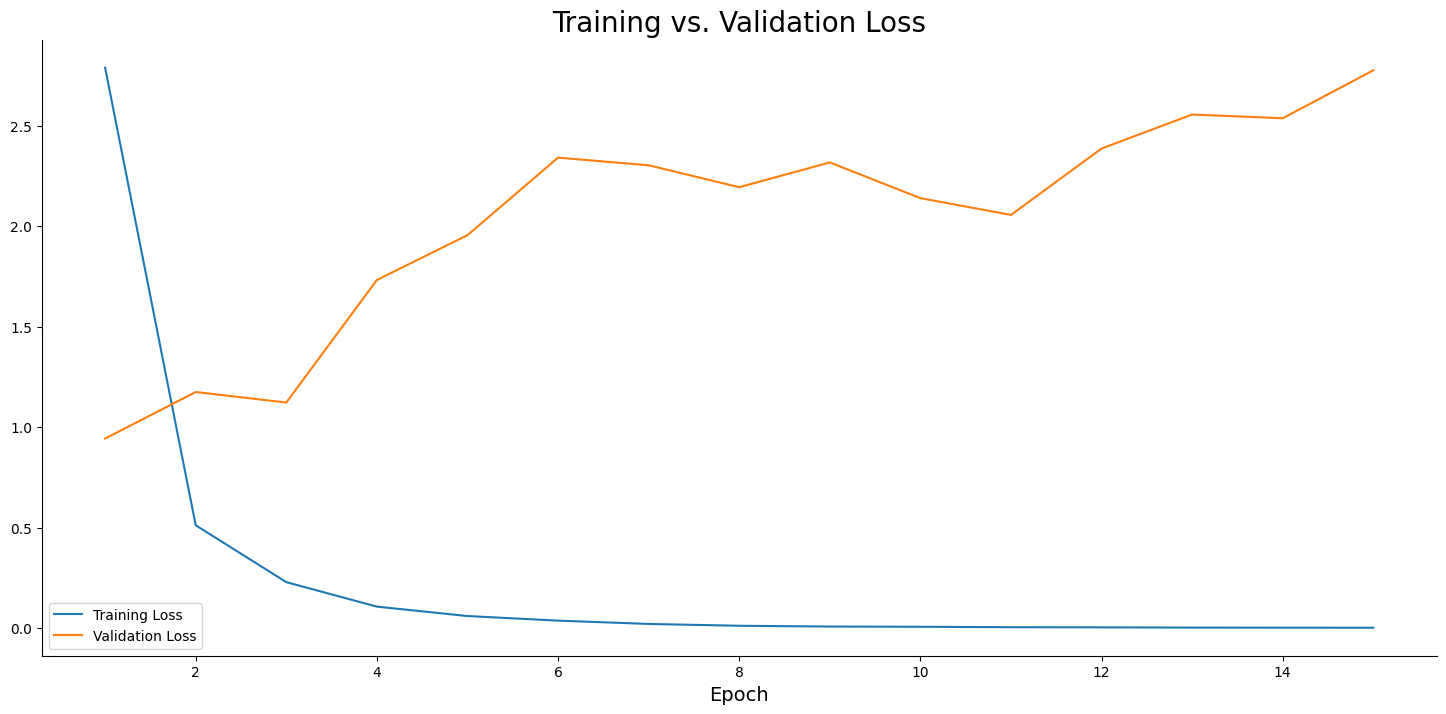

In [63]:
plt.plot(np.arange(1, 16), history_2.history['loss'], label='Training Loss')
plt.plot(np.arange(1, 16), history_2.history['val_loss'], label='Validation Loss')
plt.title('Training vs. Validation Loss', size=20)
plt.xlabel('Epoch', size=14)
plt.legend();

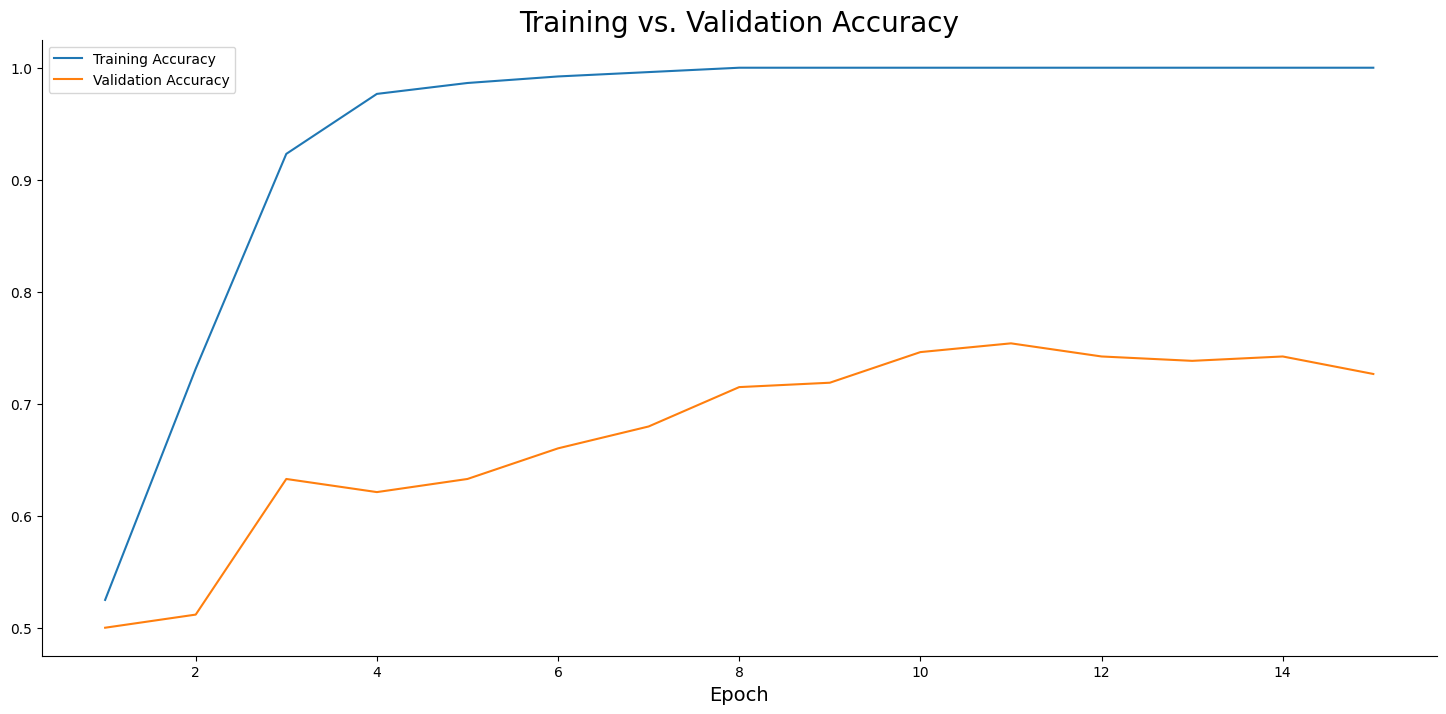

In [64]:
plt.plot(np.arange(1, 16), history_2.history['accuracy'], label='Training Accuracy')
plt.plot(np.arange(1, 16), history_2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs. Validation Accuracy', size=20)
plt.xlabel('Epoch', size=14)
plt.legend();

#### Задание (10 баллов)

Для закрепленного за Вами варианта лабораторной работы:

1. Загрузите заданный в индивидуальном задании набор данных с изображениями из Tensorflow Datasets с разбиением на обучающую и тестовую выборки.

2. Визуализируйте несколько изображений, отобранных случайным образом из обучающей выборки.

3. Оставьте в наборе изображения двух классов, указанных в индивидуальном задании первыми. Обучите нейронные сети MLP и CNN задаче бинарной классификации изображений (требования к архитектуре сетей указаны в индивидуальном задании). Отследите обучение нейронных сетей и укажите, на сколько процентов снизились в результате обучения потери по отношению к потерям на первой эпохе обучения. Оцените результаты обучения нейронных сетей (варианты: нейронная сеть обучилась, недообучилась, переобучилась).   

4. Постройте кривые обучения нейронных сетей бинарной классификации для показателей потерь и доли верных ответов в зависимости от эпохи обучения, подписывая оси и рисунок и создавая легенду.

5. Сравните качество бинарной классификации нейронными сетями при помощи показателя качества, указанного в индивидуальном задании.

6. Визуализируйте ROC-кривые для построенных классификаторов на одном рисунке (с легендой) и вычислите площади под ROC-кривыми.

7. Оставьте в наборе изображения трех классов, указанных в индивидуальном задании. Обучите нейронные сети MLP и CNN задаче многоклассовой классификации изображений (требования к архитектуре сетей указаны в индивидуальном задании).

8. Сравните качество многоклассовой классификации нейронными сетями при помощи показателя качества, указанного в индивидуальном задании.

9. Постройте кривые обучения нейронных сетей многоклассовой классификации для показателей ошибки и доли верных ответов в зависимости от эпохи обучения, подписывая оси и рисунок и создавая легенду.

